In [69]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib as mpl

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import geopandas as gpd


# 1 Forecasting the U.S. 2024 Election

Using the 2024 county-level presidential results (`pres_2024_results.csv`), fit two classification models to predict whether a given county voted for Trump. You should use `sklearn` where possible to set up your ML pipeline.

In [70]:
df = pd.read_csv("pres_2024_results.csv")
df.head()

,county_name,votes_dem,votes_rep,votes_total,count_precincts,X.1,state_name,county_fips,fips,countypop,medianincome,hsgradpct,collegegradpct,internetaccesspct,whitepopulationpct,nonwhitepopulationpct,dem_vote_share_2020
0,Abbeville County,3399.0,8502.0,12041.0,15.0,2286,South Carolina,45001,45001,24541,36685,0.346459,0.113697,0.630856,0.698382,0.301618,0.372343
1,Accomack County,7376.0,9660.0,17177.0,16.0,2789,Virginia,51001,51001,32412,43210,0.388006,0.110998,0.627735,0.683281,0.316719,0.457390
2,Ada County,116116.0,143759.0,267419.0,197.0,522,Idaho,16001,16001,469966,63137,0.229826,0.252677,0.798198,0.907168,0.092832,0.520864
3,Adair County,3632.0,16419.0,20310.0,38.0,760,Iowa,19001,19001,7063,51859,0.430974,0.116152,0.720872,0.977962,0.022038,0.354238
4,Adair County,3632.0,16419.0,20310.0,38.0,964,Kentucky,21001,21001,19215,39346,0.387427,0.077700,0.649908,0.945949,0.054051,0.193854


## 1.1 Create a binary variable
Create a binary variable indicating whether Trump won a given county (`trumpwon`) that is 1 if `gop_vote_share > 0.5`, and 0 otherwise.  
Use `train_test_split` with an 85% train / 15% test split and seed = `2025`.

In [71]:
df.columns

Index(['county_name', 'votes_dem', 'votes_rep', 'votes_total',
       'count_precincts', 'X.1', 'state_name', 'county_fips', 'fips',
       'countypop', 'medianincome', 'hsgradpct', 'collegegradpct',
       'internetaccesspct', 'whitepopulationpct', 'nonwhitepopulationpct',
       'dem_vote_share_2020'],
      dtype='object')

In [72]:
# Compute GOP vote share
df['gop_vote_share'] = df['votes_rep'] / df['votes_total']

# Create binary variable 'trumpwon' (1 if gop_vote_share > 0.5, else 0)
df['trumpwon'] = (df['gop_vote_share'] > 0.5).astype(int)

# Select relevant features
features = [
    'medianincome',
    'hsgradpct',
    'collegegradpct',
    'internetaccesspct',
    'whitepopulationpct',
    'dem_vote_share_2020'
]

X = df[features]
y = df['trumpwon']

# Split the data (85% train, 15% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2025)

# Return shapes to verify
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2643, 6), (467, 6), (2643,), (467,))

## 1.2 Logistic Regression
Use `LogisticRegression()` from `sklearn` to estimate a logit model using the following explanatory variables:

- `medianincome`: logged median income  
- `hsgradpct`: percent of high school grads  
- `collegegradpct`: percent of college grads  
- `internetaccesspct`: percent of households with internet  
- `whitepopulationpct`: percent of non-white population  
- `dem vote share 2020`: Biden vote share in 2020  

Print the following evaluation metrics for both train and test sets:
- Accuracy  
- Sensitivity  
- Specificity  
- F1 Score


In [73]:
# Initialize and fit logistic regression model
logit = LogisticRegression(max_iter=1000)
logit.fit(X_train, y_train)

# Predict on train and test
y_train_pred = logit.predict(X_train)
y_test_pred = logit.predict(X_test)

# Define a function to calculate evaluation metrics
def evaluate(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    sens = recall_score(y_true, y_pred)  # Sensitivity = Recall (for positive class)
    cm = confusion_matrix(y_true, y_pred)
    spec = cm[0,0] / (cm[0,0] + cm[0,1])  # Specificity = TN / (TN + FP)
    f1 = f1_score(y_true, y_pred)
    return {
        "Accuracy": acc,
        "Sensitivity": sens,
        "Specificity": spec,
        "F1 Score": f1
    }

# Evaluate on both train and test
train_metrics = evaluate(y_train, y_train_pred)
test_metrics = evaluate(y_test, y_test_pred)

train_metrics, test_metrics

({'Accuracy': 0.7616345062429057,
  'Sensitivity': 0.9472222222222222,
  'Specificity': 0.365361803084223,
  'F1 Score': 0.844059405940594},
 {'Accuracy': 0.7751605995717344,
  'Sensitivity': 0.9480122324159022,
  'Specificity': 0.37142857142857144,
  'F1 Score': 0.8551724137931035})

## 1.3 Random Forest
Use `RandomForestRegressor()` from `sklearn` to re-run the model using a random forest.  
Print the same metrics as above for both train and test sets.

In [74]:
# Train a random forest classifier (note: not regressor!)
rf = RandomForestClassifier(random_state=2025)
rf.fit(X_train, y_train)

# Predict on train and test
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

# Evaluate
train_metrics_rf = evaluate(y_train, y_train_pred_rf)
test_metrics_rf = evaluate(y_test, y_test_pred_rf)

train_metrics_rf, test_metrics_rf

({'Accuracy': 1.0, 'Sensitivity': 1.0, 'Specificity': 1.0, 'F1 Score': 1.0},
 {'Accuracy': 0.7580299785867237,
  'Sensitivity': 0.9113149847094801,
  'Specificity': 0.4,
  'F1 Score': 0.840620592383639})

## 1.4 Permutation Importance
Use `permutation_importance` from `sklearn`:
- What is the most important predictor in the logit model?  
- What is the most important predictor in the random forest?

In [75]:
# Permutation importance for logistic regression
perm_logit = permutation_importance(logit, X_test, y_test, random_state=2025)
logit_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_logit.importances_mean
}).sort_values(by='importance', ascending=False)

# Permutation importance for random forest
perm_rf = permutation_importance(rf, X_test, y_test, random_state=2025)
rf_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': perm_rf.importances_mean
}).sort_values(by='importance', ascending=False)

logit_importances, rf_importances

(               feature  importance
 5  dem_vote_share_2020    0.111349
 4   whitepopulationpct   -0.000428
 3    internetaccesspct   -0.001713
 2       collegegradpct   -0.002141
 1            hsgradpct   -0.002141
 0         medianincome   -0.003854,
                feature  importance
 5  dem_vote_share_2020    0.105782
 2       collegegradpct    0.014989
 0         medianincome    0.002141
 1            hsgradpct    0.001285
 4   whitepopulationpct   -0.007281
 3    internetaccesspct   -0.009850)

## 1.5 Model Comparison Table
Provide a table comparing the overall accuracy of the two models:
- Which method performs best?  
- Justify your choice of evaluation metric.

In [76]:
# Create a comparison table
comparison_df = pd.DataFrame({
    "Metric": ["Accuracy", "Sensitivity", "Specificity", "F1 Score"],
    "Logistic Regression (Test)": [
        round(test_metrics["Accuracy"], 3),
        round(test_metrics["Sensitivity"], 3),
        round(test_metrics["Specificity"], 3),
        round(test_metrics["F1 Score"], 3)
    ],
    "Random Forest (Test)": [
        round(test_metrics_rf["Accuracy"], 3),
        round(test_metrics_rf["Sensitivity"], 3),
        round(test_metrics_rf["Specificity"], 3),
        round(test_metrics_rf["F1 Score"], 3)
    ]
})

comparison_df

,Metric,Logistic Regression (Test),Random Forest (Test)
0,Accuracy,0.775,0.758
1,Sensitivity,0.948,0.911
2,Specificity,0.371,0.400
3,F1 Score,0.855,0.841


Although both models perform fairly well, **Logistic Regression** slightly outperforms Random Forest on this test set. Overall, **Logistic Regression** provides the best balance across metrics, with the **highest F1 Score**.

I select **F1 Score** as the key evaluation metric because it balances both **precision** and **recall**, especially important in imbalanced datasets like this one.

- High **sensitivity** means the model correctly captures most Trump-voting counties (true positives).
- **Specificity** ensures it’s not just labeling every county as Trump-won.
- **F1 Score** penalizes extreme trade-offs between the two, offering a more holistic measure of model performance.

In this context, Logistic Regression offers strong generalization with less risk of overfitting than the Random Forest model.

## 1.6 Midterm Prediction Extension
What changes would you make to this model to predict outcomes in the 2026 midterms?

To adapt this model for predicting the **2026 midterms**, I would make several adjustments:

1. **Target Variable**
   - Midterms have **lower turnout** and **different voter dynamics** compared to presidential elections.
   - Instead of predicting Trump vs. non-Trump, we might shift to:
     - Predicting Republican vs. Democrat in **House or Senate races**
     - Or using **vote margin thresholds** as the target.

2. **Updated Data**
   - Incorporate **2022 midterm results** and any **recent special elections** as part of training data.
   - Include **updated county-level demographics** and **economic indicators** (e.g., 2025 ACS data).

3. **Additional Features**
   - Add variables reflecting midterm-specific predictors like:
     - **Presidential approval rating**
     - **Unemployment rate**
     - **Voter registration changes**
     - **News sentiment / social media engagement**

4. **Model Tuning**
   - Use **cross-validation** and possibly ensemble methods to reduce overfitting (especially for RF).
   - Consider **class weighting** if party outcomes are imbalanced.

5. **Temporal Validation**
   - Train on 2020 + 2022 → validate on 2024 or held-out counties.
   - This would simulate "future" prediction performance more realistically.

**Overall**, predicting midterms will require more context-aware modeling — incorporating time-sensitive signals and acknowledging that voter behavior shifts outside of presidential cycles.

# 2 Create a ‘Fragile’ State Index


## 2.1 Principal Component Analysis

What makes a “weak” or “fragile” state? We will use PCA and K-Means clustering to identify what factors plausibly explain variation in state capacity using cross-sectional data (`statecap.csv`) on different socio-economic and military indicators from the World Bank.

In [77]:
statecap = pd.read_csv("statecap.csv")
statecap.head()

,iso2c,year,country,iso3c,gdp_per_capita,infant_mortality,life_expectancy,militaryexpenditures_pctgdp,land,population,military_personnel,badneighborhood,rivalries,IGO_count,cinc
0,AE,2022,United Arab Emirates,ARE,42687.720718,4.3,79.196,NaN,71020.0,9771000.0,63000.0,0.0,2,60,0.003857
1,AF,2022,Afghanistan,AFG,377.665627,44.8,62.879,NaN,652230.0,38042000.0,278000.0,0.0,1,40,0.002815
2,AL,2022,Albania,ALB,5154.827498,8.4,76.833,1.210983,27400.0,2867000.0,8000.0,0.0,0,60,0.000195
3,AM,2022,Armenia,ARM,4791.004817,9.2,73.372,4.081746,28470.0,2958000.0,49000.0,0.0,1,46,0.000600
4,AO,2022,Angola,AGO,2382.022640,45.7,61.929,1.316820,1246700.0,31825000.0,117000.0,0.0,0,50,0.002778


### 2.1.1 Handle any missing data
- Identify and handle missing data appropriately.
- Justify your approach (e.g., imputation, dropping rows, etc.).

In [78]:
statecap.isnull().sum()

iso2c                           3
year                            0
country                         3
iso3c                           3
gdp_per_capita                  5
infant_mortality                3
life_expectancy                 3
militaryexpenditures_pctgdp    26
land                            4
population                      3
military_personnel              9
badneighborhood                 1
rivalries                       0
IGO_count                       0
cinc                            0
dtype: int64

Dropping Rows:

I dropped three rows with more than 50% missing values because they lacked critical data across economic, health, and military indicators, making them unusable for PCA and clustering.

In [79]:
statecap[statecap.isnull().sum(axis=1) > statecap.shape[1] / 2]

,iso2c,year,country,iso3c,gdp_per_capita,infant_mortality,life_expectancy,militaryexpenditures_pctgdp,land,population,military_personnel,badneighborhood,rivalries,IGO_count,cinc
51,ER,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,41,0.002263
154,SS,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,25,0.001874
167,TW,2022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1,8,0.006812


In [80]:
statecap_cleaned = statecap[statecap.isnull().sum(axis=1) <= statecap.shape[1] / 2].copy()
statecap_cleaned.shape

(176, 15)

Fill with median:

For the remaining missing values in numeric columns, I filled them using the column-wise median to preserve the overall distribution while minimizing the impact of outliers.

In [81]:
numeric_cols = ['gdp_per_capita', 'militaryexpenditures_pctgdp', 'land', 'military_personnel']
statecap_cleaned[numeric_cols] = statecap_cleaned[numeric_cols].fillna(statecap_cleaned[numeric_cols].median())

Fill with mode:

For the binary variable badneighborhood, I filled missing values using the mode (most frequent value), which maintains the categorical distribution without introducing bias.

In [82]:
statecap_cleaned['badneighborhood'] = statecap_cleaned['badneighborhood'].fillna(
    statecap_cleaned['badneighborhood'].mode()[0]
)

Duplicates:

Many countries appeared multiple times in the dataset with varying values. To retain the most informative entry, I kept only the row with the highest IGO_count.

In [83]:
statecap_cleaned = statecap_cleaned.sort_values('IGO_count', ascending=False)
statecap_cleaned = statecap_cleaned.drop_duplicates(subset='country', keep='first')

Issue of Namibia:

Since Namibia’s ISO2 code ('NA') was originally missing and could be misinterpreted as a null value, I set it to 'NA_' to ensure clarity and prevent issues in downstream processing.

In [84]:
statecap_cleaned[statecap_cleaned['country']=='Namibia']

,iso2c,year,country,iso3c,gdp_per_capita,infant_mortality,life_expectancy,militaryexpenditures_pctgdp,land,population,military_personnel,badneighborhood,rivalries,IGO_count,cinc
118,NaN,2022,Namibia,NAM,3903.733408,28.6,58.059,2.917236,823290.0,2495000.0,16000.0,0.0,0,54,0.000213


In [85]:
statecap_cleaned.loc[
    (statecap_cleaned['country'] == 'Namibia') & (statecap_cleaned['iso2c'].isnull()),
    'iso2c'
] = 'NA_'

In [86]:
statecap_cleaned.isnull().sum()

iso2c                          0
year                           0
country                        0
iso3c                          0
gdp_per_capita                 0
infant_mortality               0
life_expectancy                0
militaryexpenditures_pctgdp    0
land                           0
population                     0
military_personnel             0
badneighborhood                0
rivalries                      0
IGO_count                      0
cinc                           0
dtype: int64

### 2.1.2 Correlation Plot
- Make a correlation plot of the main attributes.
- What features have the strongest correlations?
- How are they related?

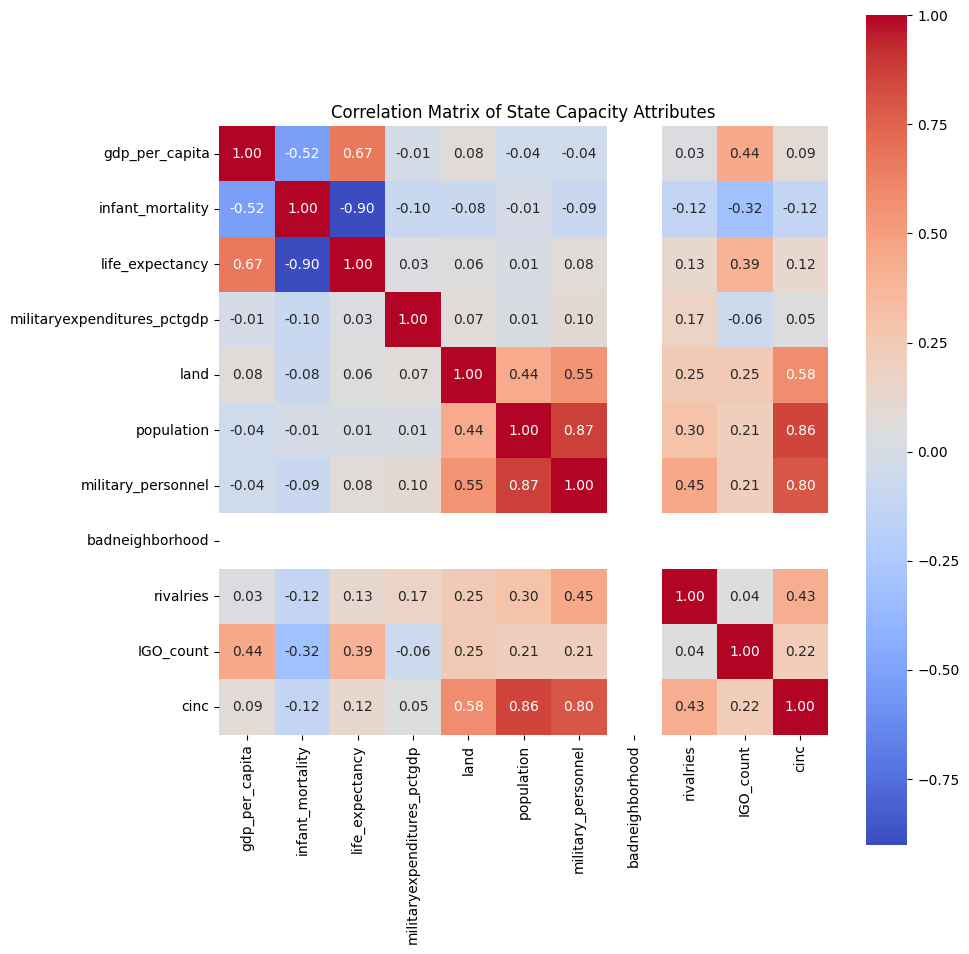

In [87]:
# Select only the relevant numeric variables for correlation
correlation_features = [
    'gdp_per_capita',
    'infant_mortality',
    'life_expectancy',
    'militaryexpenditures_pctgdp',
    'land',
    'population',
    'military_personnel',
    'badneighborhood',
    'rivalries',
    'IGO_count',
    'cinc'
]

# Compute correlation matrix
corr_matrix = statecap_cleaned[correlation_features].corr()

# Plot
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix of State Capacity Attributes")
plt.tight_layout()
plt.show()

- Life Expectancy & Infant Mortality: -0.90
  - Countries with higher life expectancy tend to have significantly lower infant mortality rates.

- Population & CINC (military power index): +0.86
  - Population size plays a key role in overall military capacity, captured by the composite index (CINC).

- Population & Military Personnel: +0.87
  - Larger populations are generally associated with larger standing armies.

### 2.1.3 Perform PCA

- Plot the biplot. Label each observation with its country name.

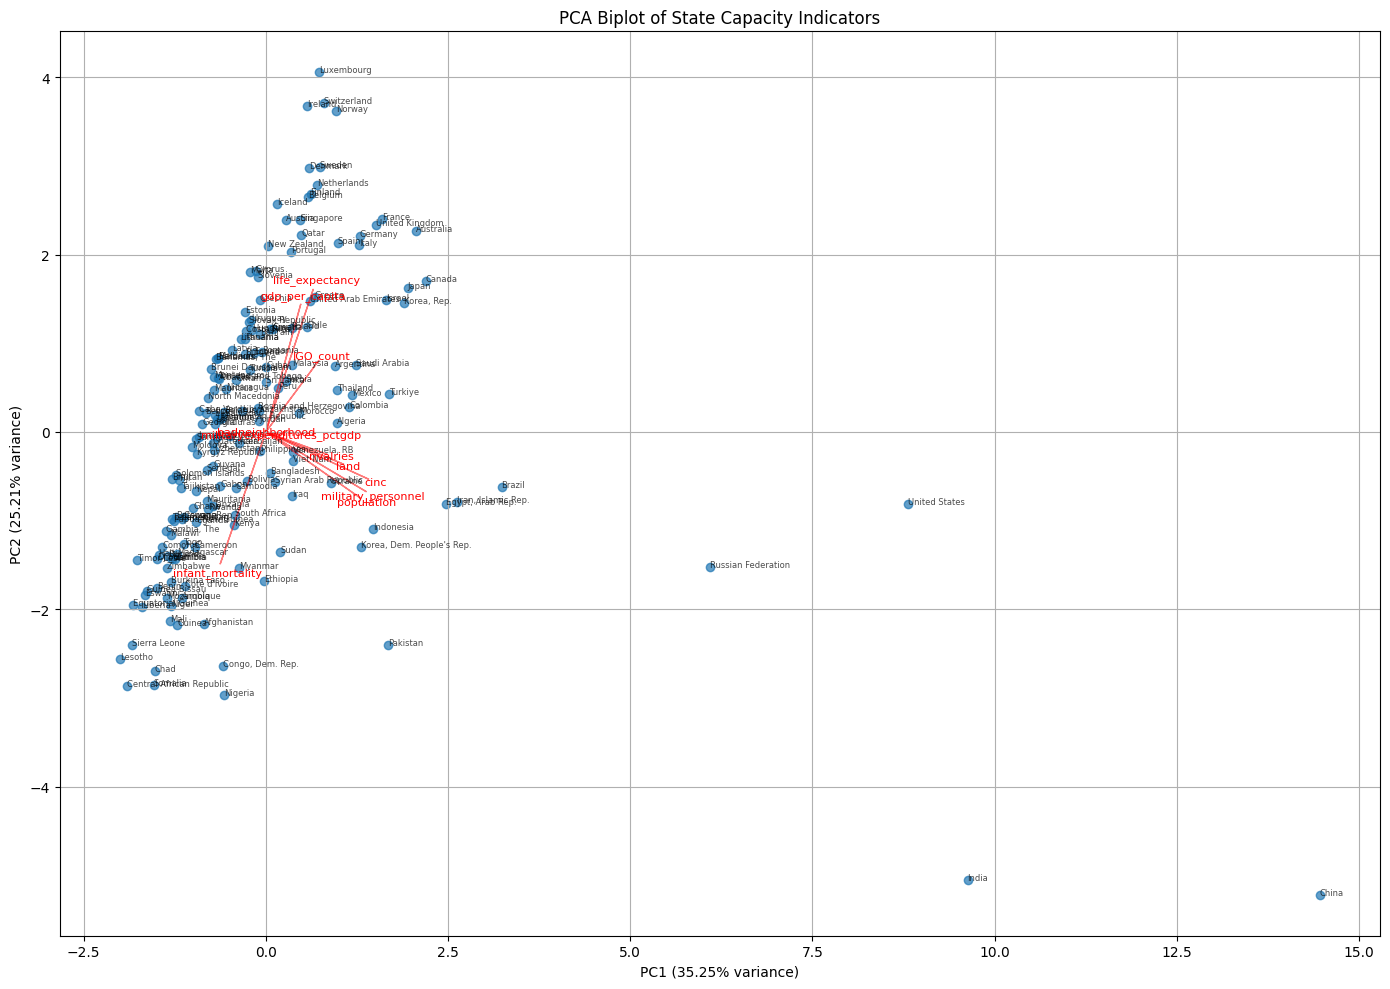

In [88]:
# Re-select numeric features for PCA
pca_features = [
    'gdp_per_capita', 'infant_mortality', 'life_expectancy', 
    'militaryexpenditures_pctgdp', 'land', 'population', 
    'military_personnel', 'badneighborhood', 'rivalries', 
    'IGO_count', 'cinc'
]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(statecap_cleaned[pca_features])

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Add PCA result to dataframe for plotting
statecap_cleaned['PC1'] = X_pca[:, 0]
statecap_cleaned['PC2'] = X_pca[:, 1]

# Biplot
plt.figure(figsize=(14, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)

# Add country labels
for i, country in enumerate(statecap_cleaned['country']):
    plt.text(X_pca[i, 0], X_pca[i, 1], country, fontsize=6, alpha=0.7)

# Plot loading vectors
loadings = pca.components_.T
for i, feature in enumerate(pca_features):
    plt.arrow(0, 0, loadings[i, 0]*3, loadings[i, 1]*3, color='red', alpha=0.5)
    plt.text(loadings[i, 0]*3.2, loadings[i, 1]*3.2, feature, color='red', ha='center', va='center', fontsize=8)

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.title("PCA Biplot of State Capacity Indicators")
plt.grid(True)
plt.tight_layout()
plt.show()

- What loading vectors are close together?
  - Population, Military Personnel, and CINC have loading vectors that point in similar directions. This suggests they form a tightly related cluster — all reflecting state size and military capacity.
  - GDP per Capita, Life Expectancy, and IGO Count are close — tied to development and international engagement.

- What attributes would you say best describe a 'weak' state and why?
  - A "weak" or fragile state typically shows:
    - High infant mortality
    - Low GDP per capita
    - Low life expectancy
    - Low IGO membership
    - High badneighborhood index (i.e., unstable neighbors)
  - These represent poor health outcomes, limited economic capacity, and geopolitical isolation — all of which limit state functionality and resilience.

- What does each of the first two principal components seem to explain?
  - PC1 (1st component) appears to capture overall development and capacity — countries with high GDP, strong international ties, and better health outcomes rank high, while weak states rank low.
  - PC2 (2nd component) seems to reflect military and territorial size — with land area, population, and military personnel loading heavily.

### 2.1.4 Create a Fragile State Index

- Create a ‘fragile state’ index from 0–100 based on the PCA results, where **higher values correspond to weaker states**.

In [89]:
# Invert PC1 so that higher values represent more fragility
fragile_raw = -statecap_cleaned['PC1'].values.reshape(-1, 1)

# Normalize to range 0–100
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 100))
fragile_index = scaler.fit_transform(fragile_raw).flatten()

# Add to dataframe
statecap_cleaned['fragile_index'] = fragile_index

# Display top 10 most fragile states
fragile_top10 = statecap_cleaned[['country', 'fragile_index']].sort_values(by='fragile_index', ascending=False).head(10)
fragile_top10.head(10)

,country,fragile_index
96,Lesotho,100.000000
28,Central African Republic,99.429405
150,Sierra Leone,98.951240
63,Equatorial Guinea,98.910580
162,Timor-Leste,98.581748
95,Liberia,98.147221
157,Eswatini,97.920837
66,Guinea-Bissau,97.747638
152,Somalia,97.170348
158,Chad,97.085729


- Compare your results to the official Fragile State Index: [fragilestatesindex.org/global-data](https://fragilestatesindex.org/global-data/)

In [90]:
rankings = pd.read_excel("Rankings.xlsx")
rankings.head()

,Country,Rank,Total,C1: Security Apparatus,C2: Factionalized Elites,C3: Group Grievance,E1: Economy,E2: Economic Inequality,E3: Human Flight and Brain Drain,P1: State Legitimacy,P2: Public Services,P3: Human Rights,S1: Demographic Pressures,S2: Refugees and IDPs,X1: External Intervention
0,Somalia,1st,111.3,9.7,10.0,9.0,9.2,9.0,8.5,9.7,9.5,8.7,10.0,9.0,9.0
1,Sudan,2nd,109.3,9.3,9.6,9.6,9.4,8.8,8.0,9.5,9.0,9.3,8.9,9.7,8.2
2,South Sudan,3rd,109.0,10.0,9.2,8.7,8.6,8.6,6.4,9.9,9.8,8.8,9.7,10.0,9.3
3,Syria,4th,108.1,9.7,9.9,8.8,9.9,6.6,7.7,10.0,9.1,8.8,8.4,9.2,10.0
4,Congo Democratic Republic,5th,106.7,8.3,9.9,9.4,8.2,8.5,6.3,9.4,9.2,9.0,9.8,9.9,8.8


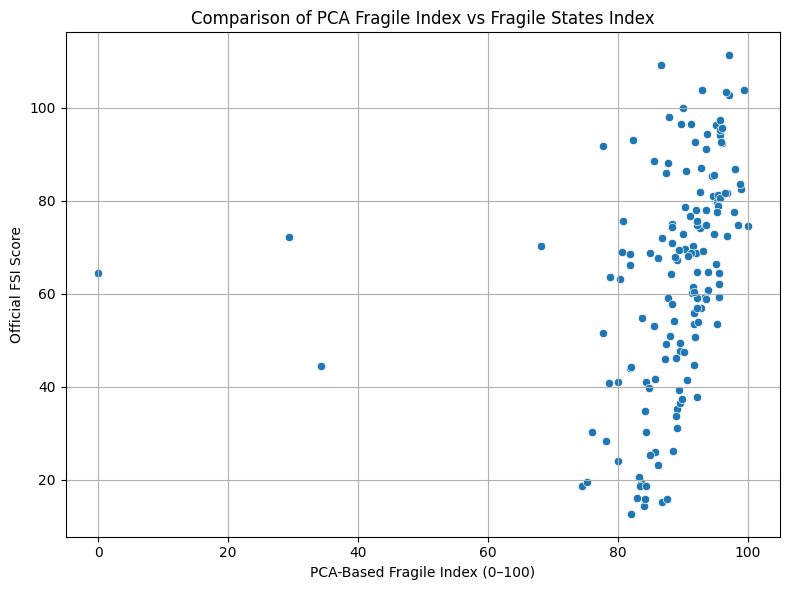

Correlation: 0.28


In [91]:
# Standardize column names
rankings.columns = rankings.columns.str.strip()

# Keep only relevant columns
fragile_official = rankings[['Country', 'Total']].copy()
fragile_official.columns = ['country', 'fsi_score']

# Merge based on country name
merged = pd.merge(statecap_cleaned, fragile_official, on='country', how='inner')

# Scatter plot of PCA vs Official FSI
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged, x='fragile_index', y='fsi_score')
plt.xlabel('PCA-Based Fragile Index (0–100)')
plt.ylabel('Official FSI Score')
plt.title('Comparison of PCA Fragile Index vs Fragile States Index')
plt.grid(True)
plt.tight_layout()
plt.show()

correlation = merged[['fragile_index', 'fsi_score']].corr().iloc[0, 1]
print(f"Correlation: {correlation:.2f}")

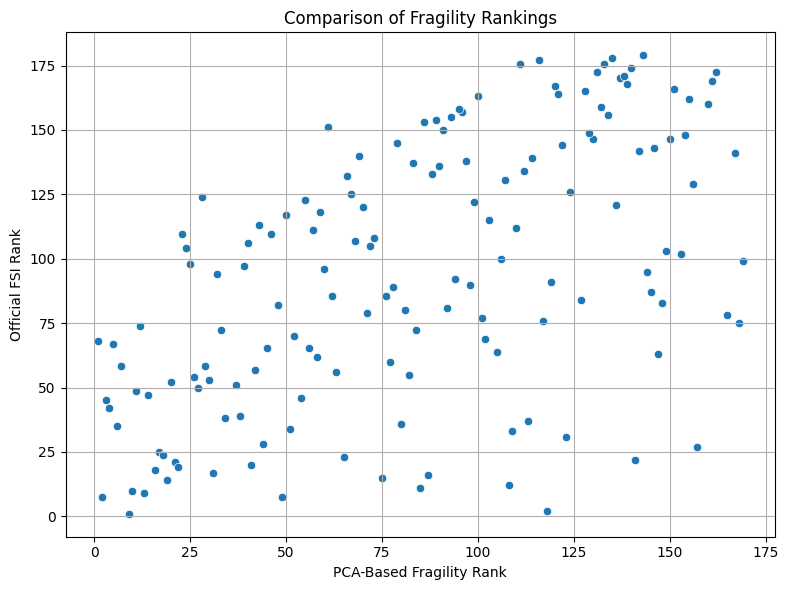

Correlation: 0.56


In [92]:
# Rank both fragile indexes (higher = more fragile)
statecap_cleaned['fragile_rank'] = statecap_cleaned['fragile_index'].rank(ascending=False)
fragile_official['fsi_rank'] = fragile_official['fsi_score'].rank(ascending=False)

# Merge ranks only
merged_ranks = pd.merge(
    statecap_cleaned[['country', 'fragile_rank']],
    fragile_official[['country', 'fsi_rank']],
    on='country', how='inner'
)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_ranks, x='fragile_rank', y='fsi_rank')
plt.xlabel('PCA-Based Fragility Rank')
plt.ylabel('Official FSI Rank')
plt.title('Comparison of Fragility Rankings')
plt.grid(True)
plt.tight_layout()
plt.show()

correlation = merged_ranks[['fragile_rank', 'fsi_rank']].corr().iloc[0, 1]
print(f"Correlation: {correlation:.2f}")

The two indexes show a strong overall trend in the same direction (positively correlated), indicating general agreement on which countries are more or less fragile. However, the rankings are not perfectly aligned, suggesting that each index may emphasize different aspects of state fragility.

## 2.2 K-Means Clustering

In [93]:
statecap_cleaned.head()

,iso2c,year,country,iso3c,gdp_per_capita,infant_mortality,life_expectancy,militaryexpenditures_pctgdp,land,population,military_personnel,badneighborhood,rivalries,IGO_count,cinc,PC1,PC2,fragile_index,fragile_rank
56,FR,2022,France,FRA,38881.223065,3.3,82.229268,1.932424,547557.0,67211000.0,304000.0,0.0,0,116,0.013378,1.594750,2.397115,78.140008,155.0
124,NO,2022,Norway,NOR,79434.625645,1.8,82.560976,1.500521,364270.0,5369000.0,23000.0,0.0,0,105,0.001573,0.961620,3.617599,81.983841,143.0
12,BE,2022,Belgium,BEL,44583.576771,3.1,81.697561,1.182396,30494.0,11483000.0,26000.0,0.0,0,102,0.002716,0.579644,2.649809,84.302881,132.0
54,FI,2022,Finland,FIN,46356.225638,1.9,81.187805,1.573638,303947.7,5533000.0,27000.0,0.0,0,102,0.001533,0.613522,2.689047,84.097203,135.0
123,NL,2022,Netherlands,NLD,51777.543168,3.4,81.714634,1.352190,33670.0,17280000.0,41000.0,0.0,0,102,0.003952,0.700051,2.783966,83.571870,137.0


### 2.2.1 Apply K-Means Clustering

Use K-means clustering with `k = 5` to create a series of country clusters.  
Label each cluster based on what you think is their defining characteristic (e.g., military capacity, health indicators, global integration).  
Are any of the clusters dominated by clearly ‘weak’ states?

In [94]:
# Run KMeans clustering on the scaled PCA features
kmeans = KMeans(n_clusters=5, random_state=42)
statecap_cleaned['cluster'] = kmeans.fit_predict(X_scaled)

# First apply KMeans (if not already)
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
statecap_cleaned['cluster'] = kmeans.fit_predict(X_scaled)

# Group countries by cluster and list them
cluster_groups = statecap_cleaned.groupby('cluster')['country'].apply(list)
for cluster_id, countries in cluster_groups.items():
    print(f"Cluster {cluster_id}: {', '.join(countries)}\n")

Cluster 0: Cameroon, South Africa, Nigeria, Cote d'Ivoire, Kenya, Senegal, Mauritania, Pakistan, Togo, Gabon, Ghana, Sudan, Burkina Faso, Benin, Guinea, Congo, Rep., Tanzania, Chad, Uganda, Mali, Niger, Sierra Leone, Mozambique, Madagascar, Zambia, Central African Republic, Gambia, The, Rwanda, Haiti, Guinea-Bissau, Burundi, Djibouti, Congo, Dem. Rep., Malawi, Zimbabwe, Comoros, Papua New Guinea, Namibia, Liberia, Somalia, Lesotho, Eswatini, Fiji, Angola, Ethiopia, Botswana, Tajikistan, Lao PDR, Equatorial Guinea, Myanmar, Afghanistan, Turkmenistan, Timor-Leste

Cluster 1: Mexico, Brazil, Colombia, Egypt, Arab Rep., Russian Federation, Argentina, Peru, Tunisia, Greece, Chile, Poland, Venezuela, RB, Morocco, Ecuador, Algeria, Panama, Bulgaria, Romania, Turkiye, Costa Rica, Malaysia, Indonesia, Nicaragua, Hungary, Bolivia, Czechia, Croatia, Slovak Republic, Uruguay, Philippines, Dominican Republic, Thailand, Slovenia, Guatemala, Paraguay, Sri Lanka, Honduras, Serbia, Bangladesh, Estonia,

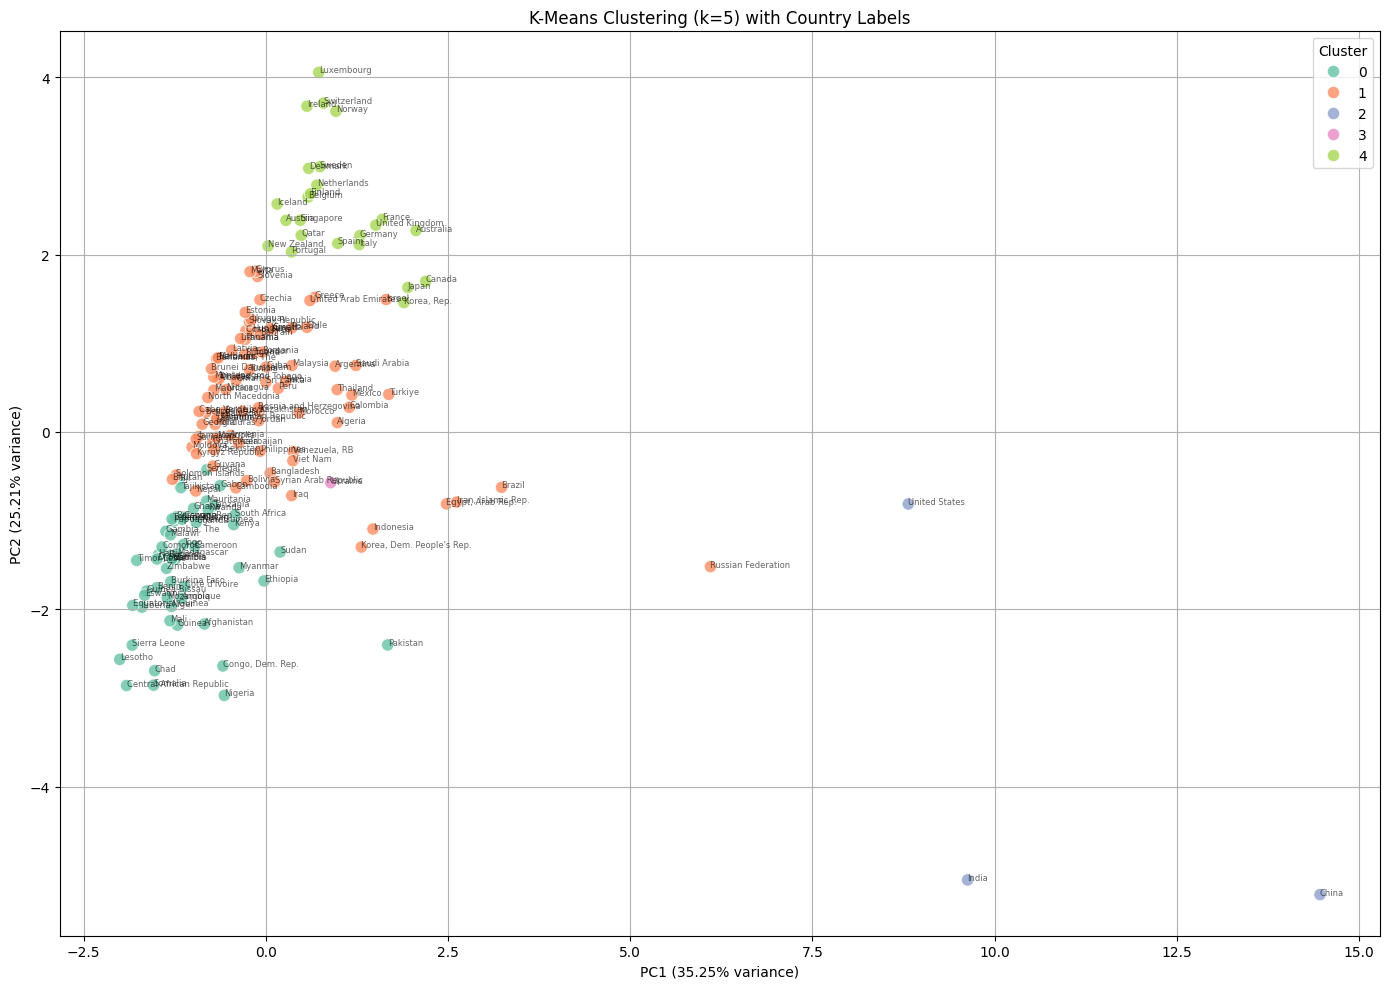

In [95]:
# Plot PCA with KMeans clusters and country labels
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='cluster',
    data=statecap_cleaned,
    palette='Set2',
    s=80,
    alpha=0.8
)

# Add country names
for _, row in statecap_cleaned.iterrows():
    plt.text(row['PC1'], row['PC2'], row['country'], fontsize=6, alpha=0.6)

plt.title("K-Means Clustering (k=5) with Country Labels")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()


- Cluster 0 – High Fragility, Low Development: Includes countries like Afghanistan, Somalia, and Haiti; characterized by weak governance, poor health outcomes, and limited international engagement.

- Cluster 1 – Emerging and Transitional States: Includes Brazil, Mexico, Egypt, and Russia; states with moderate development and mixed geopolitical stability.

- Cluster 2 – Global Strategic Powers: Consists of the U.S., China, and India; dominant global players with large economies, militaries, and populations.

- Cluster 3 – High-Capacity, Conflict-Affected: Ukraine stands alone; high baseline state capacity but currently impacted by war and instability.

- Cluster 4 – High-Capacity Developed States: Includes Germany, Japan, Canada, and Nordic countries; wealthy, stable democracies with strong institutions and low fragility.

Cluster 0 and Cluster 3 are clearly dominated by 'weak' states

### 2.2.2 Sample & Compare States from Cluster 1 and Cluster 4

Randomly sample two countries from **Cluster 1** and **Cluster 4**.  
Compare their socioeconomic and military indicators.  
Comment on how similar or dissimilar they appear within and across clusters.

In [96]:
# Randomly sample 2 countries each from Cluster 1 and Cluster 4
sample_cluster1 = statecap_cleaned[statecap_cleaned['cluster'] == 1].sample(2, random_state=4)
sample_cluster4 = statecap_cleaned[statecap_cleaned['cluster'] == 4].sample(2, random_state=4)

# Combine and show key indicators for comparison
compare_cols = ['country', 'cluster', 'gdp_per_capita', 'infant_mortality', 'life_expectancy',
                'militaryexpenditures_pctgdp', 'military_personnel', 'IGO_count', 'cinc']

comparison_df = pd.concat([sample_cluster1, sample_cluster4])[compare_cols]
comparison_df

,country,cluster,gdp_per_capita,infant_mortality,life_expectancy,militaryexpenditures_pctgdp,military_personnel,IGO_count,cinc
103,Montenegro,1,7889.237633,2.3,76.187805,1.607465,12000.0,50,0.000060
46,Algeria,1,4544.466881,18.7,77.129000,4.695022,317000.0,80,0.004547
137,Qatar,4,64315.626367,4.5,81.559000,6.962166,22000.0,56,0.001844
126,New Zealand,4,42320.892439,3.9,82.760976,1.171828,9000.0,67,0.000862


I randomly sampled two countries from Cluster 1 (**Montenegro** and **Algeria**) and Cluster 4 (**Qatar** and **New Zealand**) to compare their socioeconomic and military indicators.

**Comparison Highlights**

- **Montenegro** (Cluster 1): 
  - Moderate GDP per capita (~$7,900), low infant mortality (2.3), relatively good life expectancy (76.2)
  - Low CINC and moderate military presence; limited IGO integration

- **Algeria** (Cluster 1):  
  - Lower GDP (~$4,500), much higher infant mortality (18.7), average life expectancy (77.1)
  - Relatively high military spending (4.7% of GDP) and personnel, decent CINC and IGO membership

- **Qatar** (Cluster 4):  
  - Exceptionally high GDP (~$64,300), low infant mortality, high life expectancy
  - Very high military expenditure (~7% of GDP), moderate IGO count, mid-tier CINC score

- **New Zealand** (Cluster 4):  
  - High GDP (~$42,300), excellent health outcomes, low military burden, and moderate international engagement

**Interpretation**

- **Cluster 1** shows internal diversity: Montenegro is more developed and health-secure, while Algeria has higher military focus and worse health indicators.
- **Cluster 4** countries are clearly more stable and economically developed, but differ in geopolitical posture: Qatar is military-heavy, New Zealand is diplomacy-focused.
- The clustering correctly groups states with **different strategies but similar capacities**, while keeping fragile or transitional states separate.



### 2.2.3 Choropleth Map

Create a **choropleth map** of the world, where each state is colored by its assigned cluster.  
Add a legend that clearly labels each cluster with the short descriptor from 2.2.1 (e.g., "High military power", "Low development", etc).

In [97]:
statecap_cleaned.head()

,iso2c,year,country,iso3c,gdp_per_capita,infant_mortality,life_expectancy,militaryexpenditures_pctgdp,land,population,military_personnel,badneighborhood,rivalries,IGO_count,cinc,PC1,PC2,fragile_index,fragile_rank,cluster
56,FR,2022,France,FRA,38881.223065,3.3,82.229268,1.932424,547557.0,67211000.0,304000.0,0.0,0,116,0.013378,1.594750,2.397115,78.140008,155.0,4
124,NO,2022,Norway,NOR,79434.625645,1.8,82.560976,1.500521,364270.0,5369000.0,23000.0,0.0,0,105,0.001573,0.961620,3.617599,81.983841,143.0,4
12,BE,2022,Belgium,BEL,44583.576771,3.1,81.697561,1.182396,30494.0,11483000.0,26000.0,0.0,0,102,0.002716,0.579644,2.649809,84.302881,132.0,4
54,FI,2022,Finland,FIN,46356.225638,1.9,81.187805,1.573638,303947.7,5533000.0,27000.0,0.0,0,102,0.001533,0.613522,2.689047,84.097203,135.0,4
123,NL,2022,Netherlands,NLD,51777.543168,3.4,81.714634,1.352190,33670.0,17280000.0,41000.0,0.0,0,102,0.003952,0.700051,2.783966,83.571870,137.0,4


/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_25051/3353045857.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('Set2', len(present_clusters))


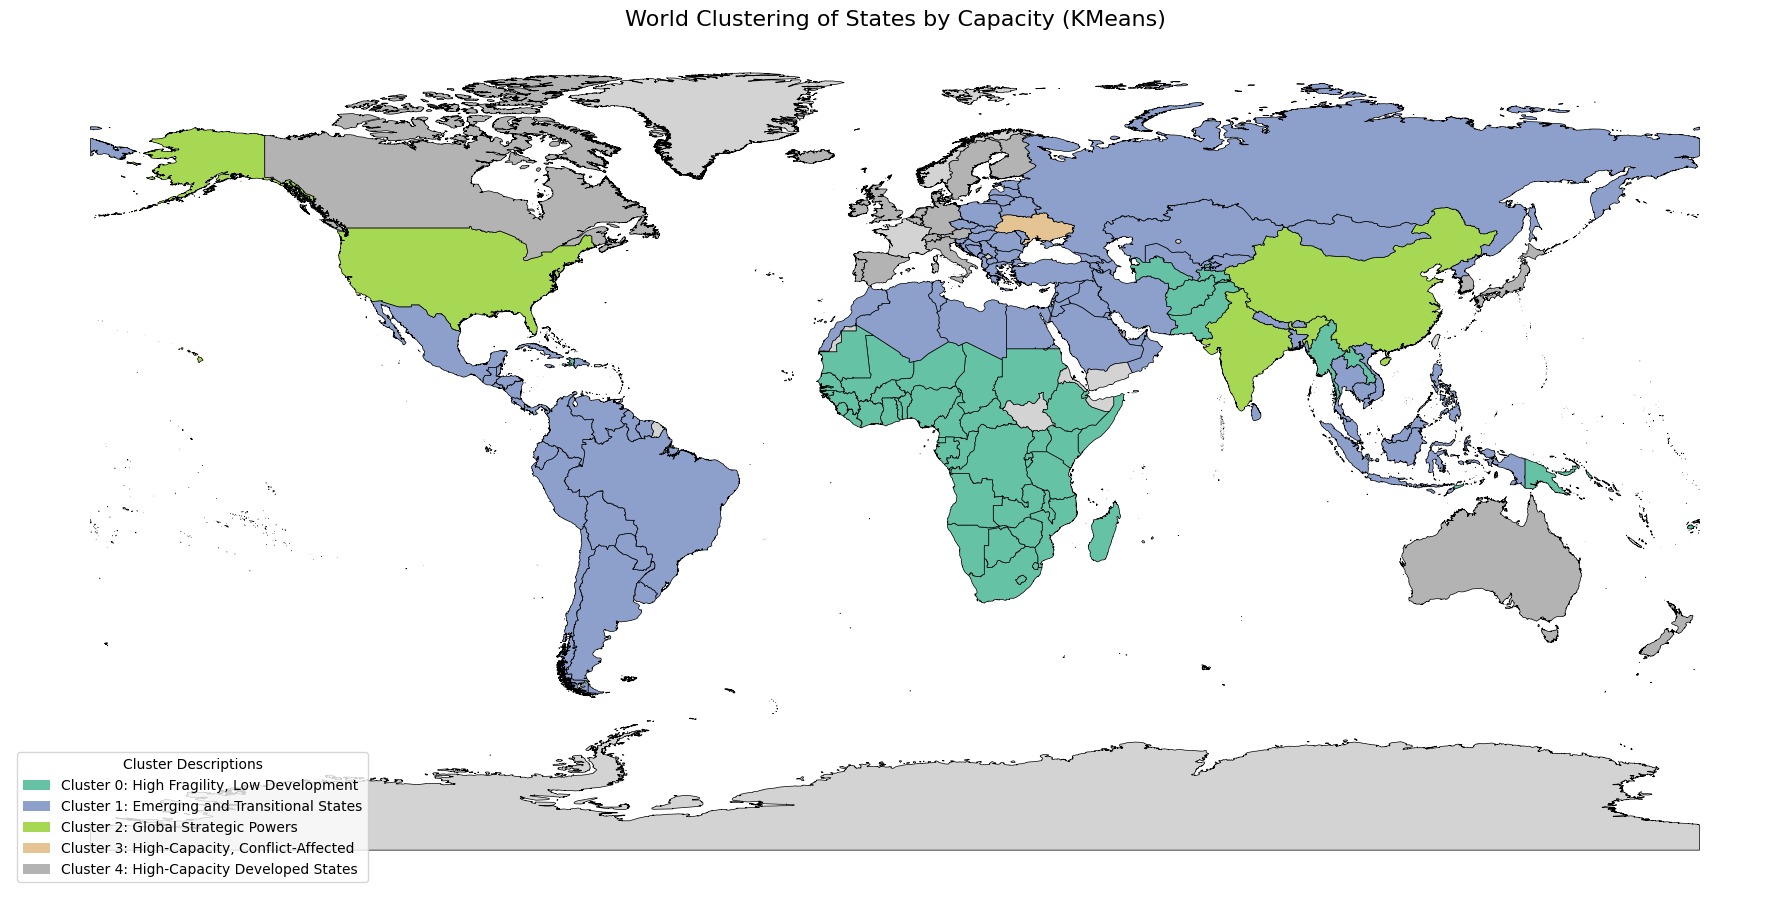

In [98]:
# Load world GeoJSON and merge
world = gpd.read_file("https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson")
map_df = world.merge(statecap_cleaned, left_on='ISO3166-1-Alpha-3', right_on='iso3c', how='left')
map_df['geometry'] = map_df['geometry'].simplify(0.01)

# Define your descriptive labels by cluster index
cluster_labels = {
    0: "High Fragility, Low Development",
    1: "Emerging and Transitional States",
    2: "Global Strategic Powers",
    3: "High-Capacity, Conflict-Affected",
    4: "High-Capacity Developed States"
}

# Get only the actual clusters present
present_clusters = sorted(map_df['cluster'].dropna().unique())

# Create colormap matching present clusters
cmap = mpl.cm.get_cmap('Set2', len(present_clusters))
cluster_color_map = {cl: cmap(i) for i, cl in enumerate(present_clusters)}

# Plot map with matched colors
fig, ax = plt.subplots(figsize=(18, 10))
map_df.plot(
    column='cluster',
    cmap=mpl.colors.ListedColormap([cluster_color_map[c] for c in present_clusters]),
    linewidth=0.5,
    edgecolor='black',
    ax=ax,
    categorical=True,
    missing_kwds={'color': 'lightgrey', 'label': 'No Data'}
)

ax.set_title("World Clustering of States by Capacity (KMeans)", fontsize=16)
ax.axis("off")

# Custom legend with correct colors and cluster meanings
legend_elements = [
    Patch(facecolor=cluster_color_map[cl], label=f"Cluster {int(cl)}: {cluster_labels[int(cl)]}")
    for cl in present_clusters
]
ax.legend(handles=legend_elements, title="Cluster Descriptions", loc='lower left')

plt.tight_layout()
plt.show()

### 2.2.4 Strategic Business Insight

If a company asked you to identify the most fragile states — and where they should avoid investing —  
Which cluster would you recommend avoiding, and why?  
How does your clustering-based recommendation compare to the **Fragile State Index** rankings?

If a company asked me to identify the most fragile states — and where they should avoid investing — I would recommend avoiding countries in **Cluster 0: High Fragility, Low Development**.

This cluster includes countries with:
- Low GDP per capita  
- High infant mortality  
- Weak infrastructure  
- Low global integration and limited institutional stability  

These indicators suggest **high political risk**, **unreliable infrastructure**, and **economic instability** — all of which pose significant threats to investment.

In [99]:
# Merge cluster result with Fragile State Index ranking
comparison_df = statecap_cleaned[['country', 'iso3c', 'cluster']].merge(
    rankings[['Country', 'Rank']], left_on='country', right_on='Country', how='left'
)

# Convert 'Rank' to numeric rank order (e.g., '1st', '2nd' -> 1, 2)
comparison_df['FSI_Rank'] = comparison_df['Rank'].str.extract(r'(\d+)').astype(float)

# Drop missing values (countries not in FSI ranking)
comparison_df = comparison_df.dropna(subset=['FSI_Rank'])
comparison_df

,country,iso3c,cluster,Country,Rank,FSI_Rank
0,France,FRA,4,France,162nd,162.0
1,Norway,NOR,4,Norway,179th,179.0
2,Belgium,BEL,4,Belgium,159th,159.0
3,Finland,FIN,4,Finland,178th,178.0
4,Netherlands,NLD,4,Netherlands,170th,170.0
...,...,...,...,...,...,...
163,Afghanistan,AFG,0,Afghanistan,7th,7.0
164,Turkmenistan,TKM,0,Turkmenistan,104th,104.0
165,Solomon Islands,SLB,1,Solomon Islands,58th,58.0
167,Bhutan,BTN,1,Bhutan,98th,98.0


/var/folders/cf/1wy60mt16_d0n286_h30f6nh0000gn/T/ipykernel_25051/1267782195.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


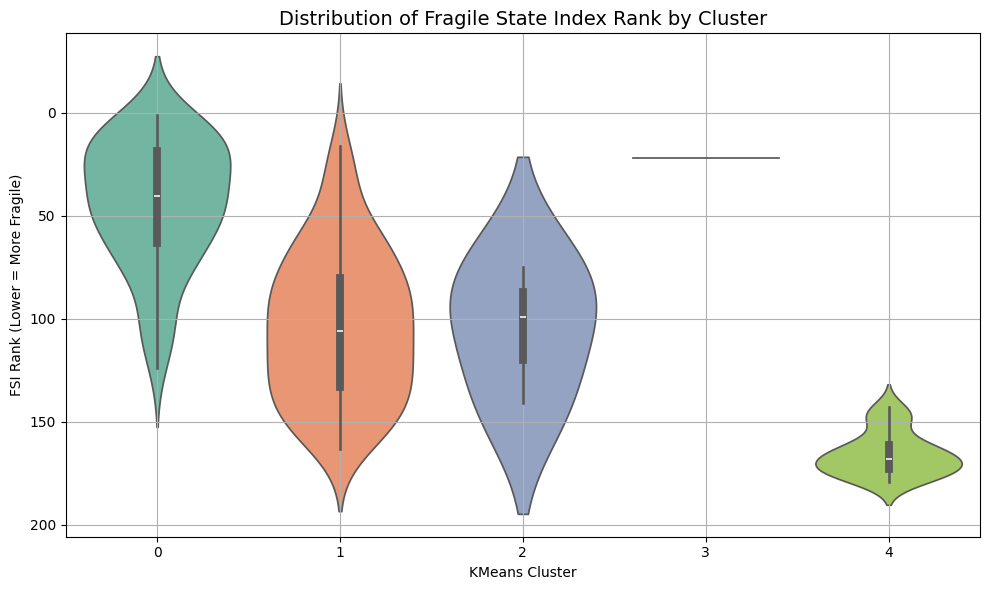

In [100]:
# Use the comparison_df from earlier (already has cluster + FSI_Rank)
plt.figure(figsize=(10, 6))

# Plot violin
sns.violinplot(
    data=comparison_df,
    x='cluster',
    y='FSI_Rank',
    palette='Set2',
    inner='box'
)

# Labeling
plt.title("Distribution of Fragile State Index Rank by Cluster", fontsize=14)
plt.xlabel("KMeans Cluster")
plt.ylabel("FSI Rank (Lower = More Fragile)")
plt.gca().invert_yaxis()  # Lower rank = more fragile, so put lowest on top
plt.grid(True)
plt.tight_layout()
plt.show()


- Cluster 0: Clearly aligns with the most fragile states — the distribution is heavily skewed toward the top ranks (low numbers), meaning it includes many of the world's most fragile countries like Somalia, Sudan, and South Sudan.

- Cluster 1: More spread out but still includes many moderately fragile states — possibly transitional economies or developing countries.

- Cluster 2: Wide distribution with some overlap with Cluster 1, but generally less fragile than Cluster 0. Possibly mixed development and stability.

- Cluster 3: Sparse and flat — looks like only 1 country is assigned here, likely an outlier (e.g., Ukraine or similar).

- Cluster 4: The most stable — all countries are ranked above 150 on the FSI (i.e., low fragility, high stability). These are your safest investment environments.